##### code reference: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [6]:
import os
import random
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils

import tqdm
import argparse

In [7]:
import face_recognition

def face_recog(image_dir):
    image_ids = os.listdir(image_dir)
    total_faces = len(image_ids)
    num_faces = 0
    for image_id in image_ids:
        image_path = os.path.join(image_dir, image_id)
        try:
            image = face_recognition.load_image_file(image_path)
            face_locations = face_recognition.face_locations(image, model="HOG")
            if len(face_locations) == 1:
                num_faces += 1
        except:
            total_faces -= 1
    acc = (num_faces / total_faces) * 100
    return acc

In [8]:
import os
import pathlib
import numpy as np
from PIL import Image
from scipy import linalg

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as TF
import torch.nn.functional as F
from torch.nn.functional import adaptive_avg_pool2d


try:
    from torchvision.models.utils import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

FID_WEIGHTS_URL = 'https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth'

class InceptionV3(nn.Module):
    DEFAULT_BLOCK_INDEX = 3
    BLOCK_INDEX_BY_DIM = {64: 0, 192: 1, 768: 2, 2048: 3}

    def __init__(self, output_blocks=(DEFAULT_BLOCK_INDEX,), resize_input=True,
                 normalize_input=True, requires_grad=False, use_fid_inception=True):
       
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3

        self.blocks = nn.ModuleList()

        if use_fid_inception:
            inception = fid_inception_v3()
        else:
            inception = _inception_v3(weights=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp


def _inception_v3(*args, **kwargs):
    try:
        version = tuple(map(int, torchvision.__version__.split('.')[:2]))
    except ValueError:
        # Just a caution against weird version strings
        version = (0,)

    if version >= (0, 6):
        kwargs['init_weights'] = False

    return torchvision.models.inception_v3(*args, **kwargs)


def fid_inception_v3():
    inception = _inception_v3(num_classes=1008, aux_logits=False, weights=False)
    inception.Mixed_5b = FIDInceptionA(192, pool_features=32)
    inception.Mixed_5c = FIDInceptionA(256, pool_features=64)
    inception.Mixed_5d = FIDInceptionA(288, pool_features=64)
    inception.Mixed_6b = FIDInceptionC(768, channels_7x7=128)
    inception.Mixed_6c = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6d = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6e = FIDInceptionC(768, channels_7x7=192)
    inception.Mixed_7b = FIDInceptionE_1(1280)
    inception.Mixed_7c = FIDInceptionE_2(2048)

    state_dict = load_state_dict_from_url(FID_WEIGHTS_URL, progress=True)
    inception.load_state_dict(state_dict)
    return inception


class FIDInceptionA(torchvision.models.inception.InceptionA):
    def __init__(self, in_channels, pool_features):
        super(FIDInceptionA, self).__init__(in_channels, pool_features)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionC(torchvision.models.inception.InceptionC):
    def __init__(self, in_channels, channels_7x7):
        super(FIDInceptionC, self).__init__(in_channels, channels_7x7)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_1(torchvision.models.inception.InceptionE):
    def __init__(self, in_channels):
        super(FIDInceptionE_1, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_2(torchvision.models.inception.InceptionE):
    def __init__(self, in_channels):
        super(FIDInceptionE_2, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


from pytorch_fid.inception import InceptionV3


IMAGE_EXTENSIONS = {'bmp', 'jpg', 'jpeg', 'pgm', 'png', 'ppm',
                    'tif', 'tiff', 'webp'}


class ImagePathDataset(torch.utils.data.Dataset):
    def __init__(self, files, transforms=None):
        self.files = files
        self.transforms = transforms

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        path = self.files[i]
        img = Image.open(path).convert('RGB')
        if self.transforms is not None:
            img = self.transforms(img)
        return img


def get_activations(files, model, batch_size=50, dims=2048, device='cpu', num_workers=1):
    model.eval()
    if batch_size > len(files):
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(files)

    dataset = ImagePathDataset(files, transforms=TF.ToTensor())
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             drop_last=False,
                                             num_workers=num_workers)

    pred_arr = np.empty((len(files), dims))

    start_idx = 0

    for batch in dataloader:
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch)[0]
            
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred = pred.squeeze(3).squeeze(2).cpu().numpy()

        pred_arr[start_idx:start_idx + pred.shape[0]] = pred

        start_idx = start_idx + pred.shape[0]

    return pred_arr


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape
    assert sigma1.shape == sigma2.shape

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1)
            + np.trace(sigma2) - 2 * tr_covmean)


def calculate_activation_statistics(files, model, batch_size=50, dims=2048, device='cpu', num_workers=0):
    act = get_activations(files, model, batch_size, dims, device, num_workers)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def compute_statistics_of_path(path, model, batch_size, dims, device, num_workers=0):
    if path.endswith('.npz'):
        with np.load(path) as f:
            m, s = f['mu'][:], f['sigma'][:]
    else:
        path = pathlib.Path(path)
        files = sorted([file for ext in IMAGE_EXTENSIONS for file in path.glob('*.{}'.format(ext))])
        m, s = calculate_activation_statistics(files, model, batch_size, dims, device, num_workers)

    return m, s


def calculate_fid_given_paths(paths, batch_size, device, dims, num_workers=0):
    for p in paths:
        if not os.path.exists(p):
            raise RuntimeError('Invalid path: %s' % p)

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    model = InceptionV3([block_idx]).to(device)
    m1, s1 = compute_statistics_of_path(paths[0], model, batch_size, dims, device, num_workers)
    m2, s2 = compute_statistics_of_path(paths[1], model, batch_size, dims, device, num_workers)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)
    return fid_value


def fid_value(paths):
    device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')
    fid_value = calculate_fid_given_paths(paths, 50, device, 2048)
    return fid_value

In [9]:
face_recog('D:/NTU/DLCV/hw2/hw2-Willy-Wen/gan_output/')

91.3

In [10]:
fid_value(['D:/NTU/DLCV/hw2/hw2-Willy-Wen/gan_output/', 'D:/NTU/DLCV/hw2/hw2_data/face/val'])

23.72194380952334

In [4]:
def normolize(x):
    a, b = x.min(), x.max()
    return (x-a)/(b-a)

def generate_images():
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(100, 100, 1, 1, device=device)
        images = generator(noise).moveaxis(1,3)
        images = normolize(images.cpu().numpy())
    return images

def output_generate_images(output_dir):
    for i in range(10):
        images = generate_images()
        for j in range(100):
            plt.imsave(f'{output_dir}/{str(i*100+j).zfill(4)}.png', images[j])
            
def set_same_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_same_seed(0)

In [5]:
def show_plot(record):
    plt.figure(figsize=(10, 6))
    plt.title("Generator and Discriminator Loss During Training")
    plt.subplot(311)
    plt.plot(record['loss_D'], label='loss_D')
    plt.plot(record['loss_G'], label='loss_G')
    plt.legend()
    plt.grid()
    plt.legend()
    plt.subplot(312)
    plt.plot(record['test_acc'], label='test_acc')
    plt.grid()
    plt.legend()
    plt.subplot(313)
    plt.plot(record['test_fid'], label='test_fid')
    plt.grid()
    plt.legend()
    plt.show()

In [6]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.img_list = [file for file in os.listdir(data_dir) if file.endswith('.png')]
        self.img_list.sort()
        self.transform=transform
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.img_list[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [7]:
data_dir = 'D:/NTU/DLCV/hw2/hw2_data/face/train'
image_size = (64, 64)
transform=transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 256

In [8]:
dataset = ImageDataset(data_dir=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

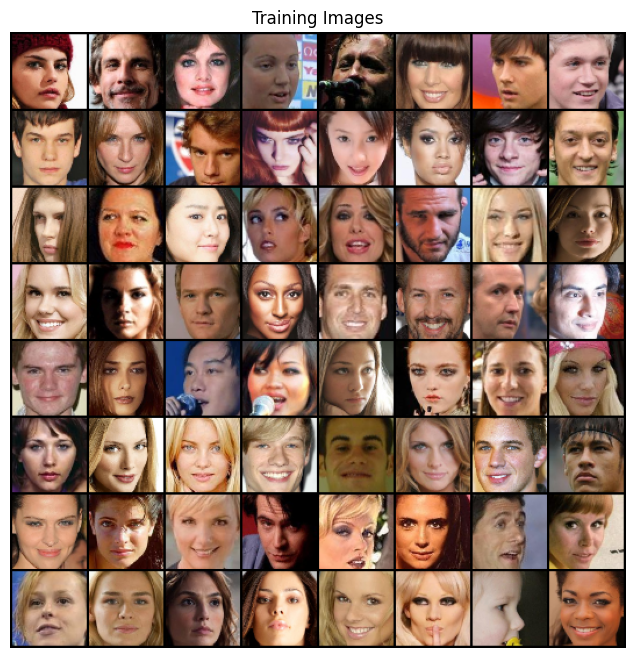

In [9]:
images_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(vutils.make_grid(images_batch[:64], padding=2, normalize=True).moveaxis(0,2))
plt.show()

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, X):
        return self.main(X)
    
generator = Generator()
generator.apply(weights_init)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
discriminator = Discriminator()
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

generator = torch.load('v1/generator_600.pth')
discriminator = torch.load('v1/discriminator_600.pth')

generator = generator.to(device)
discriminator = discriminator.to(device)

record = {'loss_D':[], 'loss_G':[], 'test_acc':[], 'test_fid':[]}
record_load = np.load('v1/record_350.npz')
record['loss_G'] = record_load['loss_G'].tolist()
record['loss_D'] = record_load['loss_D'].tolist()
record['test_acc'] = record_load['test_acc'].tolist()
record['test_fid'] = record_load['test_fid'].tolist()

cuda:0


In [14]:
def make_label(n, label=0, device=device):
    if label==0:
        return torch.zeros((n,), dtype=torch.float, device=device)
    else:
        return torch.ones((n,), dtype=torch.float, device=device)

In [15]:
# noise = torch.randn(128, nz, 1, 1, device=device)
# fake = generator(noise)
# fake.shape

In [16]:
def train_loop():
    
    generator.train()
    discriminator.train()
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    step = int(num_batches/10)
    loss_D, loss_G = 0, 0
    
    for batch, data in enumerate(dataloader):
        # train D
        discriminator.zero_grad()
        data = data.to(device)
        b_size = data.size(0)
        label = make_label(b_size, 1)
        output = discriminator(data).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = generator(noise)
        label = make_label(b_size, 0)
        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        optimizerD.step()
        loss_D += errD
        
        # train G
        generator.zero_grad()
        data = data.to(device)
        b_size = data.size(0)
        label = make_label(b_size, 1)
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = generator(noise)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        loss_G += errG
        
        if batch%step == 0:
            current = (batch+1)*len(data)
            print(f"[{batch:3d}/{num_batches:3d}] loss_D: {errD:.7f}, loss_G: {errG:.7f}, D_x: {D_x:.4f}, D_G_z: {D_G_z1:.4f}/{D_G_z2:.4f}")
        
    loss_D /= num_batches
    loss_G /= num_batches
    
    print(f"Train | loss_D: {loss_D:.8f}, loss_G: {loss_G:.8f}")
    return loss_D, loss_G

In [17]:
# train_loop()

In [18]:
def test_loop(test_dir):
    output_generate_images(test_dir)
    acc = face_recog(test_dir)
    fid = fid_value([test_dir, 'D:/NTU/DLCV/hw2/hw2_data/face/val'])
    print(f"Test  | accuracy: {acc:.2f}%, FID: {fid:.4f}\n")
    return acc, fid

In [19]:
# test_loop('gan_output/')

In [20]:
# show_plot(record)

In [21]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))

Epoch 351
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.2440829, loss_G: 8.9574146, D_x: 0.9927, D_G_z: 0.1765/0.0006
[ 15/151] loss_D: 0.1100384, loss_G: 3.6442003, D_x: 0.9669, D_G_z: 0.0654/0.0575
[ 30/151] loss_D: 0.0839996, loss_G: 4.8197432, D_x: 0.9653, D_G_z: 0.0428/0.0219
[ 45/151] loss_D: 0.0657347, loss_G: 6.2569227, D_x: 0.9826, D_G_z: 0.0435/0.0078
[ 60/151] loss_D: 0.1069058, loss_G: 3.0988805, D_x: 0.9169, D_G_z: 0.0156/0.1005
[ 75/151] loss_D: 0.1723918, loss_G: 3.6201208, D_x: 0.9693, D_G_z: 0.1072/0.0657
[ 90/151] loss_D: 0.2908704, loss_G: 6.1630812, D_x: 0.9966, D_G_z: 0.2163/0.0072
[105/151] loss_D: 0.0719965, loss_G: 4.3555937, D_x: 0.9758, D_G_z: 0.0438/0.0315
[120/151] loss_D: 0.0700521, loss_G: 4.7580614, D_x: 0.9710, D_G_z: 0.0364/0.0269
[135/151] loss_D: 0.0795097, loss_G: 4.6458135, D_x: 0.9508, D_G_z: 0.0258/0.0304
[150/151] loss_D: 0.0908686, loss_G: 5.7908144, D_x: 0.9870, D_G_z: 0.0644/0.0059


[ 90/151] loss_D: 0.0622909, loss_G: 5.2265658, D_x: 0.9871, D_G_z: 0.0448/0.0144
[105/151] loss_D: 0.0532008, loss_G: 4.4609461, D_x: 0.9780, D_G_z: 0.0290/0.0332
[120/151] loss_D: 0.0566840, loss_G: 4.7795396, D_x: 0.9880, D_G_z: 0.0418/0.0219
[135/151] loss_D: 0.0812762, loss_G: 4.3125277, D_x: 0.9549, D_G_z: 0.0311/0.0330
[150/151] loss_D: 0.0504619, loss_G: 5.2746725, D_x: 0.9679, D_G_z: 0.0168/0.0108
Train | loss_D: 0.09181215, loss_G: 4.55079174
Test  | accuracy: 88.50%, FID: 28.3491

Epoch 359
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0617376, loss_G: 3.7263637, D_x: 0.9584, D_G_z: 0.0173/0.0615
[ 15/151] loss_D: 0.1113664, loss_G: 5.4835882, D_x: 0.9972, D_G_z: 0.0923/0.0096
[ 30/151] loss_D: 0.0730778, loss_G: 5.3405309, D_x: 0.9860, D_G_z: 0.0534/0.0188
[ 45/151] loss_D: 0.0497716, loss_G: 5.3235068, D_x: 0.9865, D_G_z: 0.0339/0.0140
[ 60/151] loss_D: 0.0353791, loss_G: 5.0028362, D_x: 0.9802, D_G_z: 0.0148/0.

[  0/151] loss_D: 0.0693350, loss_G: 4.4148531, D_x: 0.9712, D_G_z: 0.0371/0.0350
[ 15/151] loss_D: 0.0720543, loss_G: 4.5998678, D_x: 0.9524, D_G_z: 0.0203/0.0253
[ 30/151] loss_D: 0.1148441, loss_G: 4.3369436, D_x: 0.9873, D_G_z: 0.0870/0.0277
[ 45/151] loss_D: 0.0470878, loss_G: 4.9782639, D_x: 0.9801, D_G_z: 0.0257/0.0200
[ 60/151] loss_D: 0.0625670, loss_G: 4.0565805, D_x: 0.9740, D_G_z: 0.0332/0.0455
[ 75/151] loss_D: 0.0483046, loss_G: 4.3734856, D_x: 0.9849, D_G_z: 0.0310/0.0299
[ 90/151] loss_D: 0.0643006, loss_G: 4.3556008, D_x: 0.9586, D_G_z: 0.0205/0.0367
[105/151] loss_D: 0.0414332, loss_G: 4.5752687, D_x: 0.9784, D_G_z: 0.0187/0.0264
[120/151] loss_D: 0.0715444, loss_G: 4.5479774, D_x: 0.9743, D_G_z: 0.0417/0.0319
[135/151] loss_D: 0.8854017, loss_G: 0.4054466, D_x: 0.4765, D_G_z: 0.0021/0.7213
[150/151] loss_D: 0.1331243, loss_G: 3.1722293, D_x: 0.9763, D_G_z: 0.0944/0.0821
Train | loss_D: 0.18323743, loss_G: 4.47099638
Test  | accuracy: 88.60%, FID: 26.7723

Epoch 367
-

[120/151] loss_D: 0.0718478, loss_G: 3.7941356, D_x: 0.9486, D_G_z: 0.0166/0.0532
[135/151] loss_D: 0.0469095, loss_G: 4.6988173, D_x: 0.9689, D_G_z: 0.0136/0.0247
[150/151] loss_D: 0.0636679, loss_G: 4.2149668, D_x: 0.9492, D_G_z: 0.0100/0.0446
Train | loss_D: 0.07135075, loss_G: 4.73799372
Test  | accuracy: 90.30%, FID: 24.7690

Epoch 374
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0625921, loss_G: 5.0188293, D_x: 0.9935, D_G_z: 0.0515/0.0171
[ 15/151] loss_D: 0.0408671, loss_G: 4.7833681, D_x: 0.9885, D_G_z: 0.0279/0.0207
[ 30/151] loss_D: 0.0690943, loss_G: 4.0558624, D_x: 0.9450, D_G_z: 0.0107/0.0410
[ 45/151] loss_D: 0.0362242, loss_G: 4.5363760, D_x: 0.9785, D_G_z: 0.0136/0.0300
[ 60/151] loss_D: 2.3348739, loss_G: 0.0321803, D_x: 0.2007, D_G_z: 0.0391/0.9719
[ 75/151] loss_D: 0.7248980, loss_G: 1.5870987, D_x: 0.7306, D_G_z: 0.2759/0.2891
[ 90/151] loss_D: 0.3371198, loss_G: 5.3266225, D_x: 0.9697, D_G_z: 0.2228/0.

[ 30/151] loss_D: 0.0734590, loss_G: 4.5858593, D_x: 0.9771, D_G_z: 0.0449/0.0285
[ 45/151] loss_D: 0.1689321, loss_G: 2.9061103, D_x: 0.8775, D_G_z: 0.0237/0.1293
[ 60/151] loss_D: 0.0840258, loss_G: 4.3765345, D_x: 0.9744, D_G_z: 0.0521/0.0368
[ 75/151] loss_D: 0.0755553, loss_G: 4.7804489, D_x: 0.9513, D_G_z: 0.0228/0.0214
[ 90/151] loss_D: 0.0593335, loss_G: 4.5068679, D_x: 0.9759, D_G_z: 0.0319/0.0316
[105/151] loss_D: 0.0648173, loss_G: 3.9141068, D_x: 0.9502, D_G_z: 0.0117/0.0476
[120/151] loss_D: 0.0649076, loss_G: 4.4125481, D_x: 0.9808, D_G_z: 0.0428/0.0335
[135/151] loss_D: 0.1015383, loss_G: 4.2814779, D_x: 0.9862, D_G_z: 0.0749/0.0394
[150/151] loss_D: 0.0739776, loss_G: 4.5760336, D_x: 0.9703, D_G_z: 0.0352/0.0251
Train | loss_D: 0.11995960, loss_G: 4.41393709
Test  | accuracy: 90.50%, FID: 25.2199

Epoch 382
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0715775, loss_G: 4.5683413, D_x: 0.9764, D_G_z: 0.0435/0.

[150/151] loss_D: 0.1212661, loss_G: 2.9866505, D_x: 0.9188, D_G_z: 0.0296/0.1235
Train | loss_D: 0.07256331, loss_G: 4.71150923
Test  | accuracy: 88.20%, FID: 24.9281

Epoch 389
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.2150343, loss_G: 7.2893686, D_x: 0.9944, D_G_z: 0.1623/0.0019
[ 15/151] loss_D: 0.0563171, loss_G: 4.2246614, D_x: 0.9700, D_G_z: 0.0240/0.0380
[ 30/151] loss_D: 0.0533907, loss_G: 4.3187513, D_x: 0.9645, D_G_z: 0.0159/0.0312
[ 45/151] loss_D: 0.0399305, loss_G: 5.0372572, D_x: 0.9760, D_G_z: 0.0148/0.0164
[ 60/151] loss_D: 0.0566164, loss_G: 4.6202106, D_x: 0.9811, D_G_z: 0.0349/0.0246
[ 75/151] loss_D: 0.0539831, loss_G: 4.6257458, D_x: 0.9721, D_G_z: 0.0237/0.0255
[ 90/151] loss_D: 0.0622282, loss_G: 5.3154902, D_x: 0.9899, D_G_z: 0.0477/0.0115
[105/151] loss_D: 0.0866002, loss_G: 5.3626842, D_x: 0.9939, D_G_z: 0.0720/0.0146
[120/151] loss_D: 0.9544344, loss_G: 1.9326065, D_x: 0.6488, D_G_z: 0.3157/0.

[ 60/151] loss_D: 0.1278844, loss_G: 2.8603563, D_x: 0.9202, D_G_z: 0.0375/0.1212
[ 75/151] loss_D: 0.1059233, loss_G: 5.1208801, D_x: 0.9600, D_G_z: 0.0547/0.0192
[ 90/151] loss_D: 0.0607680, loss_G: 4.3689713, D_x: 0.9656, D_G_z: 0.0232/0.0372
[105/151] loss_D: 0.0626925, loss_G: 4.7173557, D_x: 0.9676, D_G_z: 0.0269/0.0262
[120/151] loss_D: 0.1224548, loss_G: 5.5906343, D_x: 0.9822, D_G_z: 0.0911/0.0104
[135/151] loss_D: 2.5646722, loss_G: 4.9380531, D_x: 0.9892, D_G_z: 0.8322/0.0206
[150/151] loss_D: 0.2002770, loss_G: 2.6505079, D_x: 0.8738, D_G_z: 0.0396/0.1452
Train | loss_D: 0.28026655, loss_G: 4.21616936
Test  | accuracy: 89.90%, FID: 26.6599

Epoch 397
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.1921372, loss_G: 4.5420384, D_x: 0.9729, D_G_z: 0.1286/0.0281
[ 15/151] loss_D: 0.1388893, loss_G: 3.0991807, D_x: 0.9230, D_G_z: 0.0483/0.1016
[ 30/151] loss_D: 0.0896377, loss_G: 5.0644975, D_x: 0.9924, D_G_z: 0.0719/0.

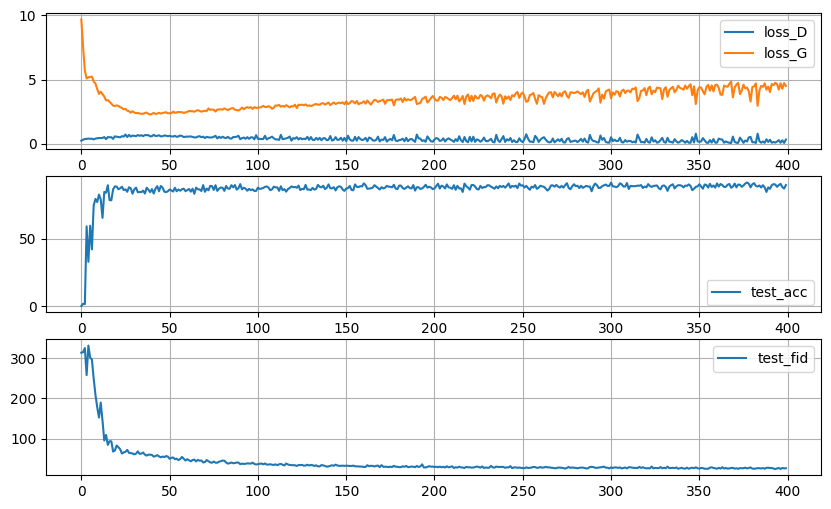

Epoch 401
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.7073873, loss_G: 3.5587058, D_x: 0.9302, D_G_z: 0.3935/0.0611
[ 15/151] loss_D: 0.5684326, loss_G: 2.7944965, D_x: 0.8688, D_G_z: 0.2887/0.1219
[ 30/151] loss_D: 0.1273890, loss_G: 4.3827543, D_x: 0.9165, D_G_z: 0.0294/0.0332
[ 45/151] loss_D: 0.6009804, loss_G: 2.9300313, D_x: 0.9077, D_G_z: 0.3393/0.1116
[ 60/151] loss_D: 0.3248522, loss_G: 6.3742180, D_x: 0.9677, D_G_z: 0.2073/0.0091
[ 75/151] loss_D: 0.0855655, loss_G: 2.8260849, D_x: 0.9756, D_G_z: 0.0543/0.1331
[ 90/151] loss_D: 0.0643849, loss_G: 3.9548039, D_x: 0.9679, D_G_z: 0.0288/0.0561
[105/151] loss_D: 0.1882885, loss_G: 2.4415550, D_x: 0.8536, D_G_z: 0.0123/0.1733
[120/151] loss_D: 0.0708897, loss_G: 3.9555521, D_x: 0.9767, D_G_z: 0.0429/0.0514
[135/151] loss_D: 0.1046396, loss_G: 5.2520943, D_x: 0.9731, D_G_z: 0.0671/0.0135
[150/151] loss_D: 0.1033180, loss_G: 4.8813004, D_x: 0.9184, D_G_z: 0.0130/0.0276


[ 90/151] loss_D: 0.0686564, loss_G: 5.1558309, D_x: 0.9432, D_G_z: 0.0078/0.0158
[105/151] loss_D: 0.0602133, loss_G: 4.6505985, D_x: 0.9590, D_G_z: 0.0165/0.0255
[120/151] loss_D: 0.0483181, loss_G: 5.3192539, D_x: 0.9874, D_G_z: 0.0319/0.0148
[135/151] loss_D: 0.1063245, loss_G: 3.8807263, D_x: 0.9130, D_G_z: 0.0102/0.0529
[150/151] loss_D: 0.0516959, loss_G: 5.0657892, D_x: 0.9616, D_G_z: 0.0113/0.0254
Train | loss_D: 0.06430077, loss_G: 4.86403131
Test  | accuracy: 90.20%, FID: 23.7800

Epoch 409
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0490475, loss_G: 4.8285294, D_x: 0.9808, D_G_z: 0.0267/0.0212
[ 15/151] loss_D: 0.0458885, loss_G: 4.2910695, D_x: 0.9856, D_G_z: 0.0297/0.0395
[ 30/151] loss_D: 0.0611082, loss_G: 4.8777313, D_x: 0.9720, D_G_z: 0.0304/0.0234
[ 45/151] loss_D: 0.0531709, loss_G: 5.1700211, D_x: 0.9720, D_G_z: 0.0225/0.0159
[ 60/151] loss_D: 0.0797251, loss_G: 4.9397483, D_x: 0.9484, D_G_z: 0.0234/0.

[  0/151] loss_D: 0.0349895, loss_G: 5.6571450, D_x: 0.9895, D_G_z: 0.0235/0.0094
[ 15/151] loss_D: 0.0585974, loss_G: 5.8405876, D_x: 0.9913, D_G_z: 0.0399/0.0088
[ 30/151] loss_D: 0.0640541, loss_G: 5.1042480, D_x: 0.9816, D_G_z: 0.0407/0.0166
[ 45/151] loss_D: 0.0343793, loss_G: 4.1405787, D_x: 0.9918, D_G_z: 0.0252/0.0426
[ 60/151] loss_D: 0.0569714, loss_G: 5.2041512, D_x: 0.9875, D_G_z: 0.0365/0.0146
[ 75/151] loss_D: 0.3052174, loss_G: 3.1647701, D_x: 0.8780, D_G_z: 0.1250/0.0903
[ 90/151] loss_D: 0.0950395, loss_G: 4.7728148, D_x: 0.9334, D_G_z: 0.0142/0.0254
[105/151] loss_D: 0.0597684, loss_G: 4.2164769, D_x: 0.9864, D_G_z: 0.0409/0.0414
[120/151] loss_D: 0.0593891, loss_G: 4.9258413, D_x: 0.9717, D_G_z: 0.0284/0.0242
[135/151] loss_D: 0.0550990, loss_G: 5.2151513, D_x: 0.9662, D_G_z: 0.0186/0.0151
[150/151] loss_D: 0.0756362, loss_G: 3.9062037, D_x: 0.9770, D_G_z: 0.0480/0.0396
Train | loss_D: 0.15902029, loss_G: 4.55970049
Test  | accuracy: 89.90%, FID: 25.5687

Epoch 417
-

[120/151] loss_D: 0.0641139, loss_G: 6.3646212, D_x: 0.9875, D_G_z: 0.0456/0.0054
[135/151] loss_D: 0.0462516, loss_G: 4.5438194, D_x: 0.9690, D_G_z: 0.0137/0.0276
[150/151] loss_D: 0.1000000, loss_G: 4.1338868, D_x: 0.9538, D_G_z: 0.0466/0.0368
Train | loss_D: 0.06271137, loss_G: 4.87125301
Test  | accuracy: 88.90%, FID: 25.0238

Epoch 424
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0797416, loss_G: 5.6777086, D_x: 0.9961, D_G_z: 0.0675/0.0114
[ 15/151] loss_D: 0.0671971, loss_G: 4.9185934, D_x: 0.9552, D_G_z: 0.0194/0.0232
[ 30/151] loss_D: 0.0340419, loss_G: 5.7885976, D_x: 0.9839, D_G_z: 0.0171/0.0089
[ 45/151] loss_D: 0.0716257, loss_G: 4.7394810, D_x: 0.9590, D_G_z: 0.0275/0.0245
[ 60/151] loss_D: 0.0436069, loss_G: 4.9992061, D_x: 0.9915, D_G_z: 0.0328/0.0205
[ 75/151] loss_D: 0.0425161, loss_G: 5.3708010, D_x: 0.9837, D_G_z: 0.0241/0.0136
[ 90/151] loss_D: 0.0946335, loss_G: 4.5342803, D_x: 0.9952, D_G_z: 0.0803/0.

[ 30/151] loss_D: 0.0717101, loss_G: 3.9065945, D_x: 0.9556, D_G_z: 0.0196/0.0559
[ 45/151] loss_D: 0.1527215, loss_G: 6.0438623, D_x: 0.9971, D_G_z: 0.1182/0.0069
[ 60/151] loss_D: 0.0333934, loss_G: 5.9220285, D_x: 0.9841, D_G_z: 0.0162/0.0102
[ 75/151] loss_D: 0.0450098, loss_G: 4.9273248, D_x: 0.9829, D_G_z: 0.0261/0.0180
[ 90/151] loss_D: 0.0686737, loss_G: 3.9451516, D_x: 0.9703, D_G_z: 0.0338/0.0542
[105/151] loss_D: 0.0345834, loss_G: 5.1871672, D_x: 0.9921, D_G_z: 0.0250/0.0216
[120/151] loss_D: 0.0666099, loss_G: 5.0976462, D_x: 0.9948, D_G_z: 0.0553/0.0152
[135/151] loss_D: 0.0580839, loss_G: 5.0529661, D_x: 0.9892, D_G_z: 0.0429/0.0213
[150/151] loss_D: 0.0441522, loss_G: 4.9169183, D_x: 0.9672, D_G_z: 0.0099/0.0248
Train | loss_D: 0.05690138, loss_G: 5.05627537
Test  | accuracy: 89.80%, FID: 25.3634

Epoch 432
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0338623, loss_G: 5.0307546, D_x: 0.9845, D_G_z: 0.0174/0.

[150/151] loss_D: 0.0519213, loss_G: 4.2968140, D_x: 0.9665, D_G_z: 0.0160/0.0313
Train | loss_D: 0.24112080, loss_G: 4.18272209
Test  | accuracy: 91.20%, FID: 26.0530

Epoch 439
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0740773, loss_G: 5.2553358, D_x: 0.9938, D_G_z: 0.0544/0.0153
[ 15/151] loss_D: 0.0542439, loss_G: 5.1048145, D_x: 0.9800, D_G_z: 0.0319/0.0192
[ 30/151] loss_D: 0.0654377, loss_G: 5.6318474, D_x: 0.9701, D_G_z: 0.0297/0.0117
[ 45/151] loss_D: 0.1849627, loss_G: 4.3621159, D_x: 0.8668, D_G_z: 0.0255/0.0361
[ 60/151] loss_D: 0.0677296, loss_G: 4.7550254, D_x: 0.9680, D_G_z: 0.0321/0.0251
[ 75/151] loss_D: 0.0505870, loss_G: 5.2330465, D_x: 0.9909, D_G_z: 0.0379/0.0183
[ 90/151] loss_D: 0.0891435, loss_G: 5.3117490, D_x: 0.9754, D_G_z: 0.0561/0.0161
[105/151] loss_D: 0.0871846, loss_G: 3.7755752, D_x: 0.9317, D_G_z: 0.0128/0.0613
[120/151] loss_D: 0.0862133, loss_G: 5.7631087, D_x: 0.9882, D_G_z: 0.0659/0.

[ 60/151] loss_D: 0.1833621, loss_G: 4.1824446, D_x: 0.9073, D_G_z: 0.0693/0.0429
[ 75/151] loss_D: 0.0955073, loss_G: 5.0261397, D_x: 0.9298, D_G_z: 0.0183/0.0200
[ 90/151] loss_D: 0.0733265, loss_G: 4.5161963, D_x: 0.9793, D_G_z: 0.0462/0.0293
[105/151] loss_D: 0.2908515, loss_G: 2.0402353, D_x: 0.7815, D_G_z: 0.0028/0.2633
[120/151] loss_D: 0.0494916, loss_G: 4.7963033, D_x: 0.9650, D_G_z: 0.0124/0.0239
[135/151] loss_D: 0.0658245, loss_G: 4.2103462, D_x: 0.9795, D_G_z: 0.0414/0.0442
[150/151] loss_D: 0.2042282, loss_G: 1.6778827, D_x: 0.8299, D_G_z: 0.0067/0.3020
Train | loss_D: 0.16069029, loss_G: 4.50875235
Test  | accuracy: 88.60%, FID: 25.3049

Epoch 447
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.7687806, loss_G: 9.9585695, D_x: 0.9994, D_G_z: 0.4400/0.0002
[ 15/151] loss_D: 0.1751132, loss_G: 3.6304417, D_x: 0.9080, D_G_z: 0.0617/0.0695
[ 30/151] loss_D: 0.0864445, loss_G: 4.8433332, D_x: 0.9818, D_G_z: 0.0601/0.

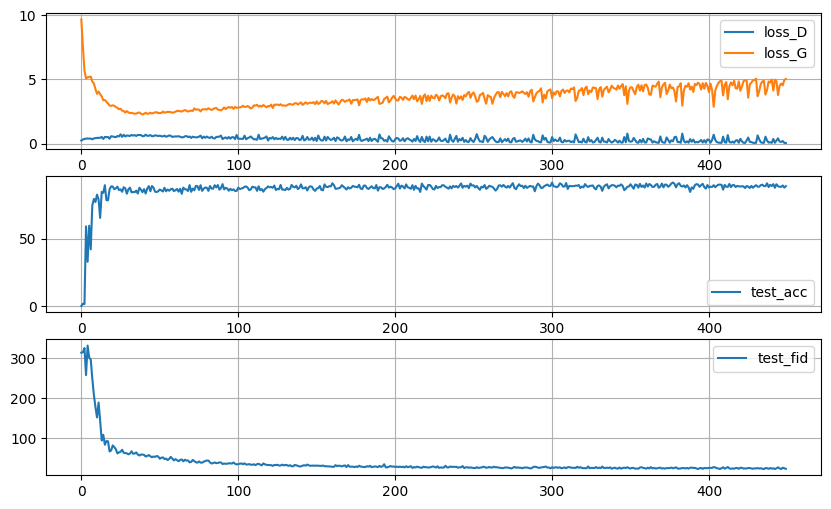

Epoch 451
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0565045, loss_G: 4.5408320, D_x: 0.9571, D_G_z: 0.0113/0.0340
[ 15/151] loss_D: 0.9216954, loss_G: 9.0995731, D_x: 0.9997, D_G_z: 0.4963/0.0004
[ 30/151] loss_D: 0.0940714, loss_G: 4.1566162, D_x: 0.9738, D_G_z: 0.0603/0.0498
[ 45/151] loss_D: 0.1131847, loss_G: 5.7005687, D_x: 0.9862, D_G_z: 0.0861/0.0094
[ 60/151] loss_D: 0.0733848, loss_G: 5.8363724, D_x: 0.9872, D_G_z: 0.0519/0.0116
[ 75/151] loss_D: 0.0496644, loss_G: 6.0156403, D_x: 0.9650, D_G_z: 0.0128/0.0075
[ 90/151] loss_D: 0.2777877, loss_G: 3.8110290, D_x: 0.8192, D_G_z: 0.0505/0.0522
[105/151] loss_D: 0.0446682, loss_G: 5.1484423, D_x: 0.9860, D_G_z: 0.0287/0.0153
[120/151] loss_D: 0.1540740, loss_G: 5.2798619, D_x: 0.9915, D_G_z: 0.1100/0.0144
[135/151] loss_D: 0.0728103, loss_G: 4.6133976, D_x: 0.9414, D_G_z: 0.0092/0.0298
[150/151] loss_D: 0.1097397, loss_G: 4.2111731, D_x: 0.9071, D_G_z: 0.0072/0.0516


[ 90/151] loss_D: 0.0241414, loss_G: 5.9761009, D_x: 0.9900, D_G_z: 0.0136/0.0072
[105/151] loss_D: 0.1295221, loss_G: 5.4713936, D_x: 0.9652, D_G_z: 0.0747/0.0139
[120/151] loss_D: 0.0535159, loss_G: 5.2296162, D_x: 0.9851, D_G_z: 0.0347/0.0190
[135/151] loss_D: 0.1158744, loss_G: 6.7284479, D_x: 0.9947, D_G_z: 0.0916/0.0055
[150/151] loss_D: 0.0263004, loss_G: 5.6459470, D_x: 0.9891, D_G_z: 0.0150/0.0096
Train | loss_D: 0.08773062, loss_G: 4.97594023
Test  | accuracy: 89.10%, FID: 25.9628

Epoch 459
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0590196, loss_G: 4.4348197, D_x: 0.9585, D_G_z: 0.0144/0.0379
[ 15/151] loss_D: 0.0782537, loss_G: 3.2255616, D_x: 0.9380, D_G_z: 0.0108/0.0980
[ 30/151] loss_D: 0.0488508, loss_G: 5.6037230, D_x: 0.9627, D_G_z: 0.0096/0.0129
[ 45/151] loss_D: 0.1167842, loss_G: 4.4113979, D_x: 0.9048, D_G_z: 0.0106/0.0298
[ 60/151] loss_D: 0.0435025, loss_G: 5.2365885, D_x: 0.9720, D_G_z: 0.0142/0.

[  0/151] loss_D: 0.0520704, loss_G: 5.4927897, D_x: 0.9916, D_G_z: 0.0385/0.0138
[ 15/151] loss_D: 0.0397365, loss_G: 5.3293543, D_x: 0.9885, D_G_z: 0.0266/0.0134
[ 30/151] loss_D: 0.0328852, loss_G: 6.2246766, D_x: 0.9834, D_G_z: 0.0151/0.0065
[ 45/151] loss_D: 0.0499903, loss_G: 5.3008432, D_x: 0.9731, D_G_z: 0.0191/0.0172
[ 60/151] loss_D: 0.0590018, loss_G: 6.4223108, D_x: 0.9478, D_G_z: 0.0028/0.0055
[ 75/151] loss_D: 0.6119806, loss_G: 1.6394920, D_x: 0.6990, D_G_z: 0.1580/0.2978
[ 90/151] loss_D: 0.1226700, loss_G: 4.1845760, D_x: 0.9160, D_G_z: 0.0262/0.0425
[105/151] loss_D: 0.0743155, loss_G: 4.8754597, D_x: 0.9676, D_G_z: 0.0370/0.0269
[120/151] loss_D: 0.0523373, loss_G: 4.8465934, D_x: 0.9747, D_G_z: 0.0244/0.0279
[135/151] loss_D: 0.0982680, loss_G: 5.9767790, D_x: 0.9883, D_G_z: 0.0744/0.0078
[150/151] loss_D: 1.2527580, loss_G: 0.9853780, D_x: 0.3531, D_G_z: 0.0079/0.4693
Train | loss_D: 0.33939281, loss_G: 4.41933393
Test  | accuracy: 88.20%, FID: 26.4025

Epoch 467
-

[120/151] loss_D: 0.0732669, loss_G: 3.9071679, D_x: 0.9598, D_G_z: 0.0288/0.0587
[135/151] loss_D: 0.1416899, loss_G: 2.8680494, D_x: 0.8964, D_G_z: 0.0210/0.1480
[150/151] loss_D: 0.0808900, loss_G: 3.6675262, D_x: 0.9476, D_G_z: 0.0210/0.0545
Train | loss_D: 0.20013338, loss_G: 4.47025156
Test  | accuracy: 89.70%, FID: 24.6765

Epoch 474
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.1289113, loss_G: 6.0721450, D_x: 0.9944, D_G_z: 0.1039/0.0072
[ 15/151] loss_D: 0.0651722, loss_G: 4.8222055, D_x: 0.9778, D_G_z: 0.0360/0.0278
[ 30/151] loss_D: 0.3940168, loss_G: 3.7327065, D_x: 0.7314, D_G_z: 0.0313/0.0657
[ 45/151] loss_D: 0.0881891, loss_G: 4.7825708, D_x: 0.9793, D_G_z: 0.0595/0.0297
[ 60/151] loss_D: 0.0758805, loss_G: 4.5685215, D_x: 0.9485, D_G_z: 0.0196/0.0385
[ 75/151] loss_D: 0.0565328, loss_G: 4.8014755, D_x: 0.9719, D_G_z: 0.0255/0.0248
[ 90/151] loss_D: 0.0668770, loss_G: 4.2624378, D_x: 0.9684, D_G_z: 0.0316/0.

[ 30/151] loss_D: 0.0998679, loss_G: 5.0809345, D_x: 0.9142, D_G_z: 0.0055/0.0175
[ 45/151] loss_D: 0.0343226, loss_G: 3.9821045, D_x: 0.9896, D_G_z: 0.0228/0.0542
[ 60/151] loss_D: 0.0489423, loss_G: 5.1980858, D_x: 0.9671, D_G_z: 0.0143/0.0185
[ 75/151] loss_D: 0.0490021, loss_G: 5.0707769, D_x: 0.9694, D_G_z: 0.0163/0.0191
[ 90/151] loss_D: 0.0490605, loss_G: 4.9279280, D_x: 0.9635, D_G_z: 0.0107/0.0223
[105/151] loss_D: 0.1389560, loss_G: 6.0076170, D_x: 0.9946, D_G_z: 0.1096/0.0076
[120/151] loss_D: 0.0271916, loss_G: 5.9168005, D_x: 0.9867, D_G_z: 0.0133/0.0083
[135/151] loss_D: 0.0750298, loss_G: 4.6375570, D_x: 0.9365, D_G_z: 0.0064/0.0296
[150/151] loss_D: 0.0226901, loss_G: 6.2778401, D_x: 0.9945, D_G_z: 0.0167/0.0056
Train | loss_D: 0.05419708, loss_G: 5.17969751
Test  | accuracy: 88.40%, FID: 24.2827

Epoch 482
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0392261, loss_G: 5.3736525, D_x: 0.9785, D_G_z: 0.0165/0.

[150/151] loss_D: 0.1177928, loss_G: 1.9277856, D_x: 0.9139, D_G_z: 0.0221/0.2948
Train | loss_D: 0.04370349, loss_G: 5.23074341
Test  | accuracy: 90.10%, FID: 24.9079

Epoch 489
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.5393596, loss_G: 10.0768270, D_x: 0.9996, D_G_z: 0.3353/0.0001
[ 15/151] loss_D: 0.6941816, loss_G: 1.7380651, D_x: 0.6410, D_G_z: 0.1438/0.2702
[ 30/151] loss_D: 0.2473563, loss_G: 3.1228576, D_x: 0.9128, D_G_z: 0.1182/0.1115
[ 45/151] loss_D: 0.1012397, loss_G: 4.1900206, D_x: 0.9553, D_G_z: 0.0451/0.0503
[ 60/151] loss_D: 0.1041205, loss_G: 5.2140207, D_x: 0.9768, D_G_z: 0.0705/0.0180
[ 75/151] loss_D: 0.1051261, loss_G: 6.2295599, D_x: 0.9658, D_G_z: 0.0525/0.0070
[ 90/151] loss_D: 0.0485447, loss_G: 4.4172239, D_x: 0.9757, D_G_z: 0.0224/0.0391
[105/151] loss_D: 0.2531826, loss_G: 7.5941062, D_x: 0.9984, D_G_z: 0.1780/0.0017
[120/151] loss_D: 0.2401367, loss_G: 3.2542331, D_x: 0.9052, D_G_z: 0.1103/0

[ 60/151] loss_D: 0.0844827, loss_G: 4.4396553, D_x: 0.9554, D_G_z: 0.0314/0.0465
[ 75/151] loss_D: 0.0656237, loss_G: 5.2355413, D_x: 0.9646, D_G_z: 0.0270/0.0219
[ 90/151] loss_D: 0.0727109, loss_G: 4.2233772, D_x: 0.9945, D_G_z: 0.0591/0.0438
[105/151] loss_D: 0.0638822, loss_G: 5.7609224, D_x: 0.9689, D_G_z: 0.0289/0.0122
[120/151] loss_D: 0.0494062, loss_G: 4.3254356, D_x: 0.9916, D_G_z: 0.0368/0.0430
[135/151] loss_D: 0.0319295, loss_G: 5.0500684, D_x: 0.9849, D_G_z: 0.0160/0.0193
[150/151] loss_D: 0.0398138, loss_G: 5.4076986, D_x: 0.9875, D_G_z: 0.0256/0.0196
Train | loss_D: 0.11529505, loss_G: 4.87971973
Test  | accuracy: 89.90%, FID: 24.3599

Epoch 497
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0380788, loss_G: 5.4013205, D_x: 0.9753, D_G_z: 0.0119/0.0173
[ 15/151] loss_D: 0.1217157, loss_G: 7.2867436, D_x: 0.9963, D_G_z: 0.0994/0.0021
[ 30/151] loss_D: 0.0646356, loss_G: 4.4395924, D_x: 0.9478, D_G_z: 0.0085/0.

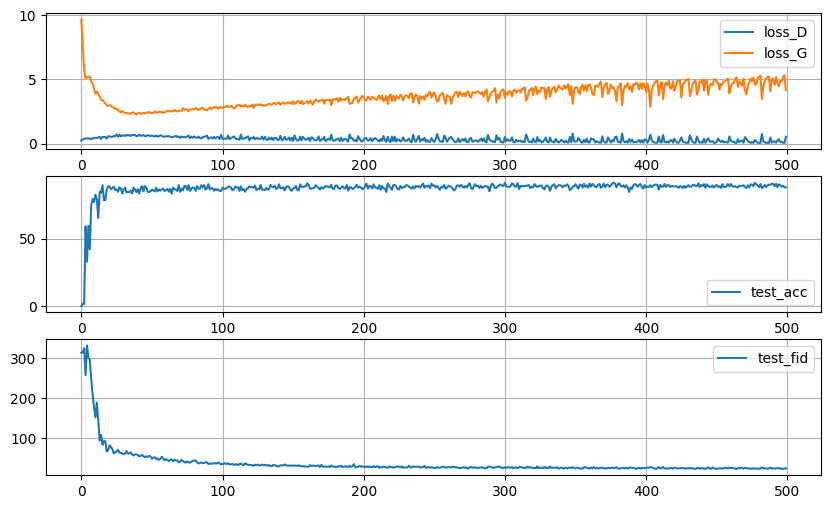

Epoch 501
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.7152681, loss_G: 2.0782764, D_x: 0.8170, D_G_z: 0.3346/0.1991
[ 15/151] loss_D: 0.6650113, loss_G: 1.4908980, D_x: 0.6279, D_G_z: 0.0684/0.3395
[ 30/151] loss_D: 0.3163239, loss_G: 3.8019214, D_x: 0.9231, D_G_z: 0.1750/0.0609
[ 45/151] loss_D: 0.2166070, loss_G: 2.4320097, D_x: 0.9216, D_G_z: 0.1015/0.1920
[ 60/151] loss_D: 0.2081648, loss_G: 2.7825205, D_x: 0.8986, D_G_z: 0.0785/0.1368
[ 75/151] loss_D: 0.2719895, loss_G: 5.4726152, D_x: 0.9604, D_G_z: 0.1706/0.0163
[ 90/151] loss_D: 0.1011117, loss_G: 5.1370821, D_x: 0.9234, D_G_z: 0.0113/0.0229
[105/151] loss_D: 0.2587678, loss_G: 2.8434625, D_x: 0.8557, D_G_z: 0.0699/0.1447
[120/151] loss_D: 0.1717212, loss_G: 4.2279410, D_x: 0.9246, D_G_z: 0.0728/0.0478
[135/151] loss_D: 0.1364222, loss_G: 4.1235986, D_x: 0.9273, D_G_z: 0.0405/0.0573
[150/151] loss_D: 0.0715433, loss_G: 4.2339668, D_x: 0.9509, D_G_z: 0.0186/0.0432


[ 90/151] loss_D: 0.0930598, loss_G: 4.1935964, D_x: 0.9533, D_G_z: 0.0372/0.0555
[105/151] loss_D: 0.2076344, loss_G: 3.6061375, D_x: 0.8359, D_G_z: 0.0084/0.0743
[120/151] loss_D: 0.0713208, loss_G: 4.3969231, D_x: 0.9522, D_G_z: 0.0171/0.0429
[135/151] loss_D: 0.0877139, loss_G: 4.8947573, D_x: 0.9335, D_G_z: 0.0141/0.0273
[150/151] loss_D: 0.0686174, loss_G: 4.5225658, D_x: 0.9718, D_G_z: 0.0353/0.0389
Train | loss_D: 0.51289552, loss_G: 3.60274553
Test  | accuracy: 87.90%, FID: 24.6007

Epoch 509
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0489428, loss_G: 4.7092304, D_x: 0.9860, D_G_z: 0.0306/0.0335
[ 15/151] loss_D: 0.0735472, loss_G: 4.9035878, D_x: 0.9527, D_G_z: 0.0210/0.0224
[ 30/151] loss_D: 0.0782537, loss_G: 5.5353460, D_x: 0.9941, D_G_z: 0.0648/0.0157
[ 45/151] loss_D: 0.0592130, loss_G: 5.1136079, D_x: 0.9920, D_G_z: 0.0464/0.0211
[ 60/151] loss_D: 0.0405437, loss_G: 4.4600201, D_x: 0.9846, D_G_z: 0.0238/0.

[  0/151] loss_D: 1.2824385, loss_G: 2.3460298, D_x: 0.8576, D_G_z: 0.5658/0.1664
[ 15/151] loss_D: 0.7710046, loss_G: 2.0032902, D_x: 0.7671, D_G_z: 0.3090/0.2190
[ 30/151] loss_D: 0.6927440, loss_G: 2.2405548, D_x: 0.8009, D_G_z: 0.3005/0.2033
[ 45/151] loss_D: 0.5781541, loss_G: 2.3494382, D_x: 0.8120, D_G_z: 0.2296/0.1766
[ 60/151] loss_D: 0.3582252, loss_G: 3.1992083, D_x: 0.8653, D_G_z: 0.1413/0.1109
[ 75/151] loss_D: 0.2009148, loss_G: 4.6485162, D_x: 0.9562, D_G_z: 0.1167/0.0378
[ 90/151] loss_D: 0.1541840, loss_G: 2.6818132, D_x: 0.8957, D_G_z: 0.0269/0.1740
[105/151] loss_D: 0.2211632, loss_G: 3.5871916, D_x: 0.8778, D_G_z: 0.0625/0.0807
[120/151] loss_D: 0.2982864, loss_G: 2.4449954, D_x: 0.7852, D_G_z: 0.0053/0.1773
[135/151] loss_D: 0.0673449, loss_G: 5.0504541, D_x: 0.9725, D_G_z: 0.0361/0.0277
[150/151] loss_D: 0.1374424, loss_G: 2.8481884, D_x: 0.9085, D_G_z: 0.0284/0.1394
Train | loss_D: 0.48730490, loss_G: 3.45131183
Test  | accuracy: 89.40%, FID: 28.6864

Epoch 517
-

[120/151] loss_D: 0.0399963, loss_G: 6.0630317, D_x: 0.9889, D_G_z: 0.0267/0.0078
[135/151] loss_D: 0.0460527, loss_G: 4.7056732, D_x: 0.9738, D_G_z: 0.0183/0.0329
[150/151] loss_D: 0.0620566, loss_G: 4.6455965, D_x: 0.9641, D_G_z: 0.0221/0.0300
Train | loss_D: 0.07090470, loss_G: 5.03376389
Test  | accuracy: 89.80%, FID: 24.9518

Epoch 524
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0311624, loss_G: 4.8950834, D_x: 0.9859, D_G_z: 0.0164/0.0260
[ 15/151] loss_D: 0.0520309, loss_G: 5.7368383, D_x: 0.9924, D_G_z: 0.0403/0.0109
[ 30/151] loss_D: 0.0303442, loss_G: 5.4330530, D_x: 0.9831, D_G_z: 0.0124/0.0155
[ 45/151] loss_D: 0.1917177, loss_G: 3.4665229, D_x: 0.8440, D_G_z: 0.0041/0.0755
[ 60/151] loss_D: 0.0554674, loss_G: 5.0654488, D_x: 0.9943, D_G_z: 0.0438/0.0226
[ 75/151] loss_D: 0.0357276, loss_G: 5.3519468, D_x: 0.9795, D_G_z: 0.0143/0.0146
[ 90/151] loss_D: 2.1460831, loss_G: 4.9165049, D_x: 0.9387, D_G_z: 0.8026/0.

[ 30/151] loss_D: 0.0341420, loss_G: 5.6225500, D_x: 0.9862, D_G_z: 0.0190/0.0119
[ 45/151] loss_D: 0.0555354, loss_G: 5.0591478, D_x: 0.9859, D_G_z: 0.0349/0.0182
[ 60/151] loss_D: 0.0502405, loss_G: 5.0644722, D_x: 0.9849, D_G_z: 0.0317/0.0229
[ 75/151] loss_D: 0.0892994, loss_G: 3.5726247, D_x: 0.9313, D_G_z: 0.0146/0.0704
[ 90/151] loss_D: 0.0470299, loss_G: 4.8488212, D_x: 0.9845, D_G_z: 0.0289/0.0246
[105/151] loss_D: 0.0476157, loss_G: 5.4486141, D_x: 0.9711, D_G_z: 0.0153/0.0163
[120/151] loss_D: 0.0460634, loss_G: 5.3737011, D_x: 0.9960, D_G_z: 0.0376/0.0154
[135/151] loss_D: 0.0490306, loss_G: 6.4680629, D_x: 0.9894, D_G_z: 0.0349/0.0061
[150/151] loss_D: 0.0179027, loss_G: 5.8164806, D_x: 0.9944, D_G_z: 0.0119/0.0098
Train | loss_D: 0.05539032, loss_G: 5.23038960
Test  | accuracy: 88.70%, FID: 25.0000

Epoch 532
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0266356, loss_G: 5.2541342, D_x: 0.9877, D_G_z: 0.0131/0.

[150/151] loss_D: 0.0527745, loss_G: 6.4799647, D_x: 0.9914, D_G_z: 0.0415/0.0069
Train | loss_D: 0.04564195, loss_G: 5.28876591
Test  | accuracy: 90.70%, FID: 25.1892

Epoch 539
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0552387, loss_G: 5.3420868, D_x: 0.9574, D_G_z: 0.0099/0.0178
[ 15/151] loss_D: 0.0470570, loss_G: 5.6461358, D_x: 0.9864, D_G_z: 0.0312/0.0139
[ 30/151] loss_D: 0.0430224, loss_G: 5.6466637, D_x: 0.9812, D_G_z: 0.0221/0.0150
[ 45/151] loss_D: 0.0315562, loss_G: 6.1192045, D_x: 0.9878, D_G_z: 0.0184/0.0064
[ 60/151] loss_D: 0.0356049, loss_G: 6.2065086, D_x: 0.9890, D_G_z: 0.0221/0.0089
[ 75/151] loss_D: 0.0278041, loss_G: 5.4494047, D_x: 0.9860, D_G_z: 0.0129/0.0145
[ 90/151] loss_D: 0.0352451, loss_G: 5.4025383, D_x: 0.9820, D_G_z: 0.0149/0.0168
[105/151] loss_D: 0.0303798, loss_G: 5.2694244, D_x: 0.9962, D_G_z: 0.0247/0.0165
[120/151] loss_D: 0.0286748, loss_G: 6.5223846, D_x: 0.9766, D_G_z: 0.0046/0.

[ 60/151] loss_D: 0.0381461, loss_G: 5.5902538, D_x: 0.9885, D_G_z: 0.0250/0.0150
[ 75/151] loss_D: 0.0343793, loss_G: 5.9635158, D_x: 0.9767, D_G_z: 0.0101/0.0084
[ 90/151] loss_D: 0.0546079, loss_G: 4.2834387, D_x: 0.9791, D_G_z: 0.0306/0.0430
[105/151] loss_D: 0.0308809, loss_G: 5.7866478, D_x: 0.9925, D_G_z: 0.0220/0.0147
[120/151] loss_D: 0.0245634, loss_G: 5.5024071, D_x: 0.9898, D_G_z: 0.0138/0.0137
[135/151] loss_D: 0.0225166, loss_G: 5.3428221, D_x: 0.9922, D_G_z: 0.0142/0.0175
[150/151] loss_D: 0.0507527, loss_G: 4.5053682, D_x: 0.9627, D_G_z: 0.0113/0.0301
Train | loss_D: 0.05243982, loss_G: 5.25720358
Test  | accuracy: 89.80%, FID: 24.0650

Epoch 547
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0425982, loss_G: 5.7795038, D_x: 0.9948, D_G_z: 0.0340/0.0106
[ 15/151] loss_D: 0.0274038, loss_G: 6.4984279, D_x: 0.9841, D_G_z: 0.0109/0.0046
[ 30/151] loss_D: 0.0537922, loss_G: 5.8657341, D_x: 0.9756, D_G_z: 0.0267/0.

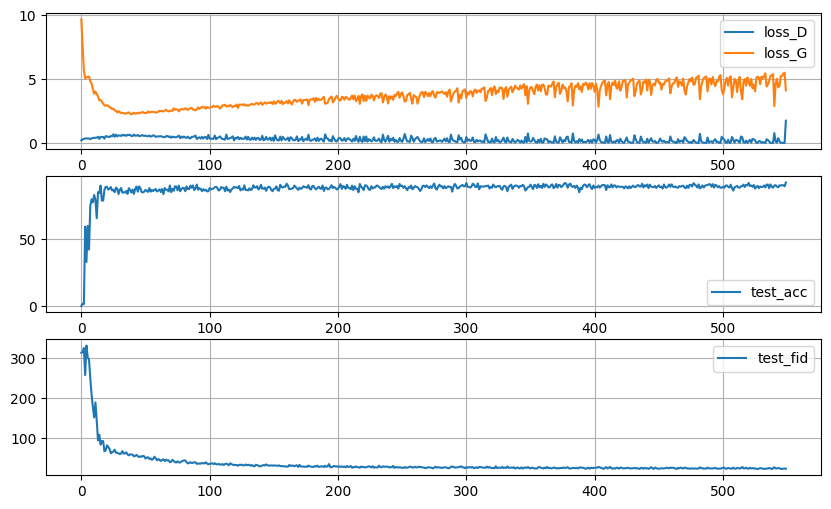

Epoch 551
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.5474879, loss_G: 6.2722073, D_x: 0.9951, D_G_z: 0.3228/0.0065
[ 15/151] loss_D: 0.0787959, loss_G: 5.3037109, D_x: 0.9822, D_G_z: 0.0517/0.0274
[ 30/151] loss_D: 0.1185107, loss_G: 4.0789814, D_x: 0.9178, D_G_z: 0.0228/0.0643
[ 45/151] loss_D: 0.5862051, loss_G: 1.8501165, D_x: 0.6502, D_G_z: 0.0057/0.2747
[ 60/151] loss_D: 0.1075830, loss_G: 4.9243126, D_x: 0.9323, D_G_z: 0.0302/0.0236
[ 75/151] loss_D: 0.1515348, loss_G: 4.6937428, D_x: 0.9552, D_G_z: 0.0869/0.0273
[ 90/151] loss_D: 0.0677067, loss_G: 5.5917487, D_x: 0.9902, D_G_z: 0.0489/0.0121
[105/151] loss_D: 0.0849794, loss_G: 4.5757289, D_x: 0.9518, D_G_z: 0.0283/0.0365
[120/151] loss_D: 0.1123797, loss_G: 5.6227255, D_x: 0.9835, D_G_z: 0.0751/0.0138
[135/151] loss_D: 0.0937122, loss_G: 5.7158022, D_x: 0.9902, D_G_z: 0.0742/0.0097
[150/151] loss_D: 5.7617297, loss_G: 0.1505323, D_x: 0.0131, D_G_z: 0.0013/0.8985


[ 90/151] loss_D: 0.0770889, loss_G: 4.1761336, D_x: 0.9485, D_G_z: 0.0207/0.0390
[105/151] loss_D: 0.0467786, loss_G: 5.2042665, D_x: 0.9769, D_G_z: 0.0211/0.0170
[120/151] loss_D: 0.0906360, loss_G: 3.9239030, D_x: 0.9315, D_G_z: 0.0142/0.0584
[135/151] loss_D: 0.0471559, loss_G: 5.1580281, D_x: 0.9760, D_G_z: 0.0215/0.0171
[150/151] loss_D: 0.0435905, loss_G: 6.2847986, D_x: 0.9887, D_G_z: 0.0307/0.0087
Train | loss_D: 0.05228658, loss_G: 5.19812155
Test  | accuracy: 90.10%, FID: 23.7656

Epoch 559
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0508146, loss_G: 5.7181292, D_x: 0.9662, D_G_z: 0.0145/0.0124
[ 15/151] loss_D: 0.0617436, loss_G: 4.7156920, D_x: 0.9705, D_G_z: 0.0250/0.0341
[ 30/151] loss_D: 0.0439492, loss_G: 4.6535568, D_x: 0.9670, D_G_z: 0.0096/0.0334
[ 45/151] loss_D: 0.4406341, loss_G: 1.3582511, D_x: 0.7017, D_G_z: 0.0008/0.4379
[ 60/151] loss_D: 0.5881242, loss_G: 4.2859530, D_x: 0.9673, D_G_z: 0.3558/0.

[  0/151] loss_D: 0.7680299, loss_G: 9.7036276, D_x: 0.9979, D_G_z: 0.4112/0.0003
[ 15/151] loss_D: 0.2703151, loss_G: 5.1439929, D_x: 0.9505, D_G_z: 0.1570/0.0214
[ 30/151] loss_D: 0.1105331, loss_G: 4.6974707, D_x: 0.9725, D_G_z: 0.0695/0.0378
[ 45/151] loss_D: 0.0553926, loss_G: 6.0210638, D_x: 0.9848, D_G_z: 0.0357/0.0105
[ 60/151] loss_D: 0.0759733, loss_G: 5.6678548, D_x: 0.9793, D_G_z: 0.0456/0.0160
[ 75/151] loss_D: 0.0473079, loss_G: 5.0848985, D_x: 0.9747, D_G_z: 0.0190/0.0190
[ 90/151] loss_D: 0.0565419, loss_G: 5.0566063, D_x: 0.9565, D_G_z: 0.0100/0.0230
[105/151] loss_D: 0.0671430, loss_G: 4.7925735, D_x: 0.9512, D_G_z: 0.0144/0.0260
[120/151] loss_D: 0.0632724, loss_G: 6.1123691, D_x: 0.9897, D_G_z: 0.0471/0.0083
[135/151] loss_D: 0.0596478, loss_G: 5.2101889, D_x: 0.9595, D_G_z: 0.0157/0.0240
[150/151] loss_D: 0.0529945, loss_G: 3.6317437, D_x: 0.9649, D_G_z: 0.0154/0.0650
Train | loss_D: 0.14034155, loss_G: 4.87172127
Test  | accuracy: 89.90%, FID: 23.9284

Epoch 567
-

[120/151] loss_D: 0.0275478, loss_G: 5.7443209, D_x: 0.9929, D_G_z: 0.0194/0.0097
[135/151] loss_D: 0.0363460, loss_G: 5.9869356, D_x: 0.9773, D_G_z: 0.0126/0.0096
[150/151] loss_D: 0.0589863, loss_G: 4.2218499, D_x: 0.9539, D_G_z: 0.0094/0.0414
Train | loss_D: 0.04379655, loss_G: 5.46053600
Test  | accuracy: 90.50%, FID: 23.8182

Epoch 574
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0526328, loss_G: 5.8472805, D_x: 0.9966, D_G_z: 0.0444/0.0109
[ 15/151] loss_D: 0.0549203, loss_G: 4.2384906, D_x: 0.9734, D_G_z: 0.0255/0.0526
[ 30/151] loss_D: 0.1186357, loss_G: 6.5177145, D_x: 0.9981, D_G_z: 0.0909/0.0059
[ 45/151] loss_D: 0.0258022, loss_G: 5.7591362, D_x: 0.9909, D_G_z: 0.0160/0.0123
[ 60/151] loss_D: 0.0559607, loss_G: 4.7461915, D_x: 0.9557, D_G_z: 0.0086/0.0312
[ 75/151] loss_D: 0.0394683, loss_G: 6.1057668, D_x: 0.9795, D_G_z: 0.0174/0.0086
[ 90/151] loss_D: 0.0490347, loss_G: 4.7630405, D_x: 0.9596, D_G_z: 0.0067/0.

[ 30/151] loss_D: 0.0251014, loss_G: 6.5412865, D_x: 0.9943, D_G_z: 0.0182/0.0057
[ 45/151] loss_D: 0.0324348, loss_G: 5.1073189, D_x: 0.9802, D_G_z: 0.0118/0.0233
[ 60/151] loss_D: 0.0300482, loss_G: 5.2932539, D_x: 0.9940, D_G_z: 0.0216/0.0182
[ 75/151] loss_D: 0.0513381, loss_G: 4.4017835, D_x: 0.9630, D_G_z: 0.0125/0.0387
[ 90/151] loss_D: 0.0369153, loss_G: 5.9756255, D_x: 0.9836, D_G_z: 0.0170/0.0081
[105/151] loss_D: 0.0641913, loss_G: 4.7562056, D_x: 0.9467, D_G_z: 0.0054/0.0275
[120/151] loss_D: 0.0501765, loss_G: 6.2401757, D_x: 0.9562, D_G_z: 0.0040/0.0099
[135/151] loss_D: 0.0256721, loss_G: 6.4521532, D_x: 0.9824, D_G_z: 0.0071/0.0060
[150/151] loss_D: 0.0362887, loss_G: 5.5106587, D_x: 0.9933, D_G_z: 0.0280/0.0189
Train | loss_D: 0.04477330, loss_G: 5.59705162
Test  | accuracy: 89.70%, FID: 23.9374

Epoch 582
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0384548, loss_G: 6.3691430, D_x: 0.9929, D_G_z: 0.0267/0.

[150/151] loss_D: 0.0562883, loss_G: 4.4426508, D_x: 0.9607, D_G_z: 0.0127/0.0467
Train | loss_D: 0.20966464, loss_G: 4.99865580
Test  | accuracy: 88.20%, FID: 25.6018

Epoch 589
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0824712, loss_G: 6.2374153, D_x: 0.9954, D_G_z: 0.0647/0.0080
[ 15/151] loss_D: 0.0698561, loss_G: 5.2158556, D_x: 0.9638, D_G_z: 0.0274/0.0243
[ 30/151] loss_D: 0.0620652, loss_G: 6.3090615, D_x: 0.9888, D_G_z: 0.0456/0.0082
[ 45/151] loss_D: 0.0684572, loss_G: 3.8854165, D_x: 0.9558, D_G_z: 0.0194/0.0640
[ 60/151] loss_D: 0.0419556, loss_G: 5.5529060, D_x: 0.9922, D_G_z: 0.0310/0.0195
[ 75/151] loss_D: 0.6558976, loss_G: 3.7953665, D_x: 0.9949, D_G_z: 0.3904/0.0623
[ 90/151] loss_D: 0.0588597, loss_G: 5.2072277, D_x: 0.9815, D_G_z: 0.0350/0.0206
[105/151] loss_D: 0.0484224, loss_G: 5.2961330, D_x: 0.9724, D_G_z: 0.0186/0.0228
[120/151] loss_D: 0.0625926, loss_G: 5.1344910, D_x: 0.9466, D_G_z: 0.0051/0.

[ 60/151] loss_D: 0.0774449, loss_G: 5.7827730, D_x: 0.9852, D_G_z: 0.0552/0.0120
[ 75/151] loss_D: 0.0438544, loss_G: 6.1614118, D_x: 0.9732, D_G_z: 0.0151/0.0085
[ 90/151] loss_D: 0.0364321, loss_G: 5.7208409, D_x: 0.9792, D_G_z: 0.0136/0.0141
[105/151] loss_D: 0.0585670, loss_G: 4.9171510, D_x: 0.9825, D_G_z: 0.0365/0.0230
[120/151] loss_D: 0.0327085, loss_G: 4.2679920, D_x: 0.9968, D_G_z: 0.0279/0.0446
[135/151] loss_D: 0.0601866, loss_G: 4.1266451, D_x: 0.9641, D_G_z: 0.0209/0.0505
[150/151] loss_D: 0.0294165, loss_G: 5.7008686, D_x: 0.9916, D_G_z: 0.0196/0.0140
Train | loss_D: 0.06848487, loss_G: 5.22022009
Test  | accuracy: 88.90%, FID: 25.3248

Epoch 597
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.0402249, loss_G: 5.3301086, D_x: 0.9725, D_G_z: 0.0115/0.0162
[ 15/151] loss_D: 0.0290345, loss_G: 6.0904322, D_x: 0.9931, D_G_z: 0.0211/0.0097
[ 30/151] loss_D: 0.0405736, loss_G: 5.9384413, D_x: 0.9840, D_G_z: 0.0226/0.

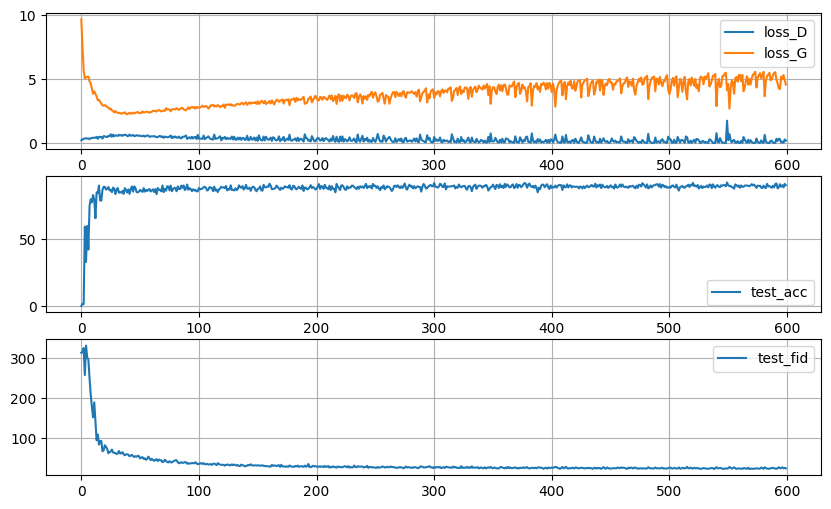

Epoch 601
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.6888995, loss_G: 3.0456400, D_x: 0.8589, D_G_z: 0.3105/0.1071
[ 15/151] loss_D: 0.0785363, loss_G: 4.6304712, D_x: 0.9691, D_G_z: 0.0387/0.0357
[ 30/151] loss_D: 0.1003965, loss_G: 4.9398413, D_x: 0.9825, D_G_z: 0.0697/0.0284
[ 45/151] loss_D: 0.1061982, loss_G: 3.8888917, D_x: 0.9224, D_G_z: 0.0143/0.0644
[ 60/151] loss_D: 0.0680850, loss_G: 5.3945088, D_x: 0.9928, D_G_z: 0.0511/0.0141
[ 75/151] loss_D: 0.1249447, loss_G: 5.5542650, D_x: 0.9906, D_G_z: 0.0943/0.0170
[ 90/151] loss_D: 0.0486270, loss_G: 5.9171705, D_x: 0.9656, D_G_z: 0.0121/0.0112
[105/151] loss_D: 0.0400846, loss_G: 5.2418480, D_x: 0.9955, D_G_z: 0.0312/0.0229
[120/151] loss_D: 0.0367517, loss_G: 5.0569124, D_x: 0.9797, D_G_z: 0.0145/0.0235
[135/151] loss_D: 0.0380870, loss_G: 4.9062104, D_x: 0.9725, D_G_z: 0.0092/0.0298
[150/151] loss_D: 0.0465083, loss_G: 5.0291615, D_x: 0.9842, D_G_z: 0.0283/0.0234


KeyboardInterrupt: 

In [29]:
num_epochs = 600

for epoch in range(1, num_epochs+1):
    ee = len(record['loss_D'])+1
    print(f"Epoch {ee}\n---------------------------------------------------------------------------------------")
    
    loss_D, loss_G = train_loop()
    test_acc, test_fid = test_loop('gan_output')
    
    record['loss_G'].append(loss_G.item())
    record['loss_D'].append(loss_D.item())
    record['test_acc'].append(test_acc)
    record['test_fid'].append(test_fid)

    if (ee%50 == 0):
        show_plot(record)
        torch.save(discriminator, f'discriminator_{ee}.pth')
        torch.save(generator, f'generator_{ee}.pth')
        np.savez(f'record_{ee}', loss_G=np.array(record['loss_G']), loss_D=np.array(record['loss_D']),
                 test_acc=np.array(record['test_acc']), test_fid=np.array(record['test_fid']))

In [ ]:
48
Test  | accuracy: 91.30%, FID: 23.7219

In [29]:
set_same_seed(48)
test_loop('gan_output')

Test  | accuracy: 91.30%, FID: 23.7219



(91.3, 23.72190708196689)

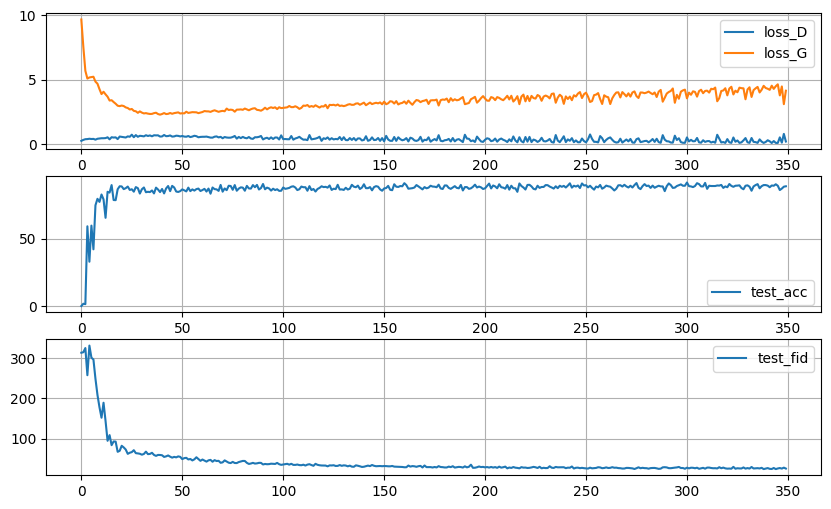

In [30]:
show_plot(record)

In [34]:
torch.save(generator, 'generator_v1.pth')
torch.save(discriminator, 'discriminator_v1.pth')
np.savez('record', loss_G=np.array(record['loss_G']), loss_D=np.array(record['loss_D']), 
         test_acc=np.array(record['test_acc']), test_fid=np.array(record['test_fid']))

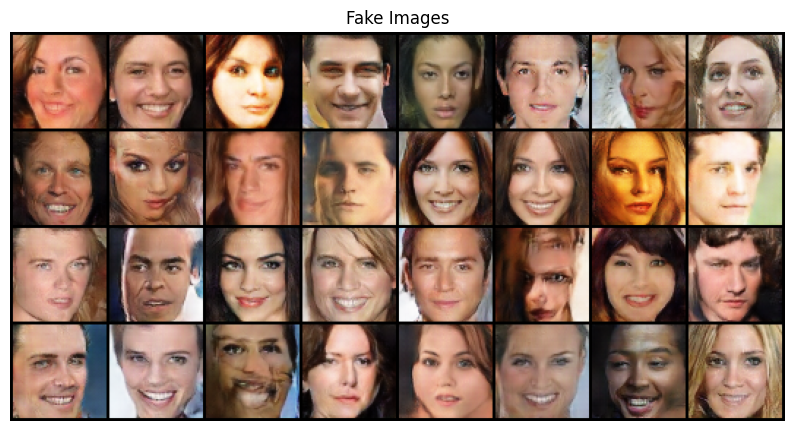

In [116]:
a = torch.randn(32, 100, 1, 1, device=device)
with torch.no_grad():
    b = generator(a).detach().cpu()
    c = (vutils.make_grid(b, nrow=8, padding=2, normalize=True))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(c,(1,2,0)))
plt.show()

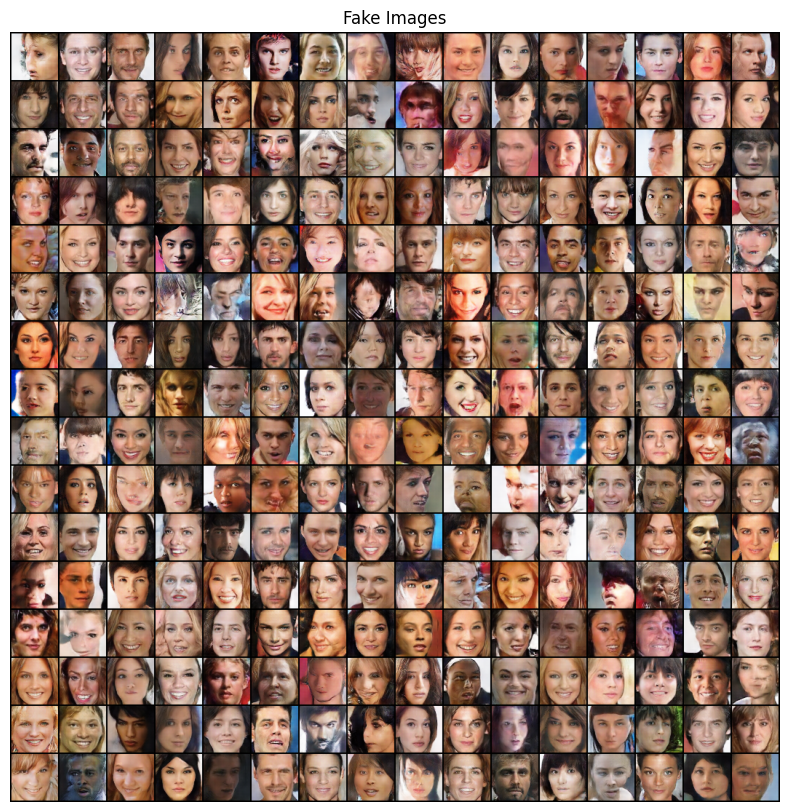

In [81]:
a = torch.randn(256, 100, 1, 1, device=device)
with torch.no_grad():
    b = generator(a).detach().cpu()
    c = (vutils.make_grid(b, nrow=16, padding=2, normalize=True))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(c,(1,2,0)))
plt.show()